In [1]:
# Import standardowych bibliotek
import pandas as pd
import numpy as np
from xgboost import XGBClassifier

# Import bibliotek do wizualizacji
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc
)

# Aktywacja wyświetlania wykresów w notebooku
%matplotlib inline

In [2]:
dataset = pd.read_csv(r'C:\Magisterka\Predicting-the-results-of-Premier-League-matches\TEST\final_dataset_2.csv')

In [3]:
# Remove few column
dataset2 = dataset.copy().drop(columns =['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG',
       'HTGS', 'ATGS', 'HTGC', 'ATGC',
       'HM4', 'HM5','AM4', 'AM5', 'MW', 'HTFormPtsStr',
       'ATFormPtsStr', 'HTFormPts', 'ATFormPts', 'HTWinStreak3',
       'HTWinStreak5', 'HTLossStreak3', 'HTLossStreak5', 'ATWinStreak3',
       'ATWinStreak5', 'ATLossStreak3', 'ATLossStreak5',
       'DiffPts'] )

In [4]:
X_all = dataset2.drop(['FTR'], axis=1)  # Użycie nazwanego argumentu axis
y_all = dataset2['FTR']

# Wybór kolumn do standaryzacji
cols = ['HTGD', 'ATGD', 'HTP', 'ATP']
X_all[cols] = scale(X_all[cols])  # Standaryzacja wybranych kolumn

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=0)

In [6]:
categorical_columns = X_train.select_dtypes(include=['object', 'category']).columns

In [7]:
if len(categorical_columns) > 0:
    X_train = pd.get_dummies(X_train, columns=categorical_columns)
    X_test = pd.get_dummies(X_test, columns=categorical_columns)
    

In [8]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [9]:
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

In [10]:
classifier = XGBClassifier(seed=82, eval_metric='logloss')
classifier.fit(X_train, y_train_encoded)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [11]:
y_pred = classifier.predict(X_test)

In [12]:
y_pred_decoded = label_encoder.inverse_transform(y_pred)

In [13]:
print(classification_report(y_test, y_pred_decoded))

              precision    recall  f1-score   support

           H       0.57      0.56      0.57       401
          NH       0.66      0.68      0.67       511

    accuracy                           0.62       912
   macro avg       0.62      0.62      0.62       912
weighted avg       0.62      0.62      0.62       912



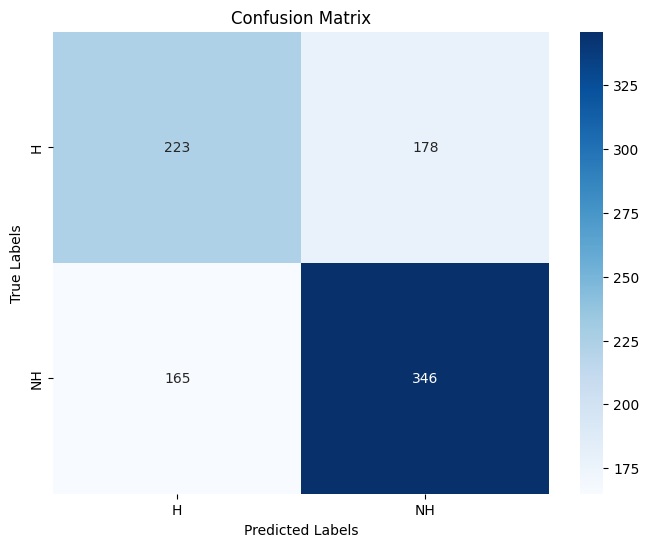

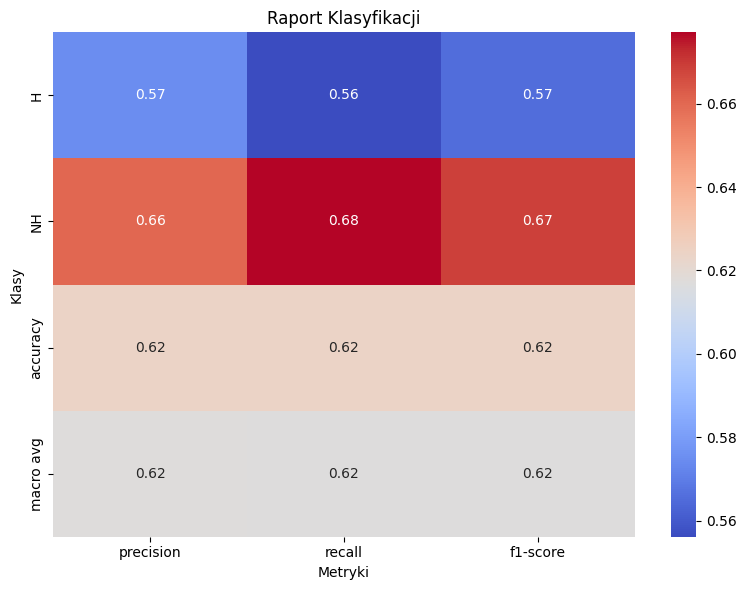

In [14]:
conf_matrix = confusion_matrix(y_test, y_pred_decoded, labels=label_encoder.classes_)

# Wykres 1: Macierz pomyłek
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

report = classification_report(y_test, y_pred_decoded, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Tworzenie heatmapy raportu klasyfikacji
plt.figure(figsize=(8, 6))
sns.heatmap(
    report_df.iloc[:-1, :-1],  # Pomijamy 'accuracy' w ostatnim wierszu i wsparcie
    annot=True, fmt='.2f', cmap='coolwarm',
    xticklabels=report_df.columns[:-1],
    yticklabels=report_df.index[:-1]
)
plt.title("Raport Klasyfikacji")
plt.xlabel("Metryki")
plt.ylabel("Klasy")
plt.tight_layout()
plt.show()


**BOOSTED XGBOOST**

In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, f1_score, classification_report
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from xgboost import XGBClassifier

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

# Sprawdź typy danych i zakoduj kolumny, jeśli to konieczne
mapping = {'L': 0, 'D': 1, 'W': 2}
for col in ['HM1', 'HM2', 'HM3', 'AM1', 'AM2', 'AM3']:  # Podaj swoje kolumny kategoryczne
    if col in X_train.columns:
        X_train[col] = X_train[col].map(mapping)
        X_test[col] = X_test[col].map(mapping)

# Kodowanie etykiet
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Definicja klasyfikatora
clf = XGBClassifier(eval_metric='logloss', random_state=42)

# Parametry do GridSearchCV
parameters = {
    'learning_rate': [0.1, 0.01],
    'n_estimators': [40, 100],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'gamma': [0.0, 0.4, 0.8],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [1e-5, 1e-2],
}


# Definiowanie metryki
f1_scorer = make_scorer(f1_score, average='weighted')

# GridSearchCV
grid_obj = GridSearchCV(clf, scoring=f1_scorer, param_grid=parameters, cv=5)

# Dopasowanie modelu do danych
grid_obj.fit(X_train, y_train_encoded)

# Wybranie najlepszego modelu
best_clf = grid_obj.best_estimator_

# Wyświetlenie najlepszych parametrów
print("Najlepsze parametry: ", grid_obj.best_params_)

# Prognozowanie na danych testowych
y_pred = best_clf.predict(X_test)

# Odkodowanie etykiet
y_pred_decoded = label_encoder.inverse_transform(y_pred)

# Ocena wyników
print(classification_report(y_test, y_pred_decoded))


Najlepsze parametry:  {'colsample_bytree': 1.0, 'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'reg_alpha': 0.01, 'subsample': 0.8}
              precision    recall  f1-score   support

           H       0.66      0.48      0.56       428
          NH       0.63      0.78      0.70       484

    accuracy                           0.64       912
   macro avg       0.64      0.63      0.63       912
weighted avg       0.64      0.64      0.63       912



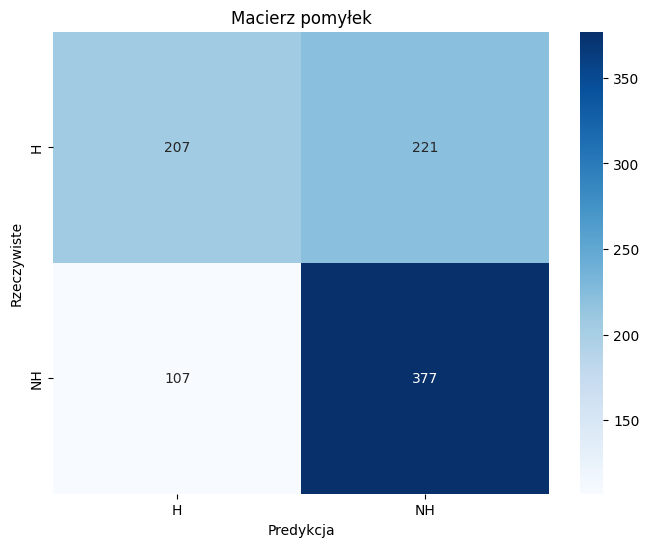

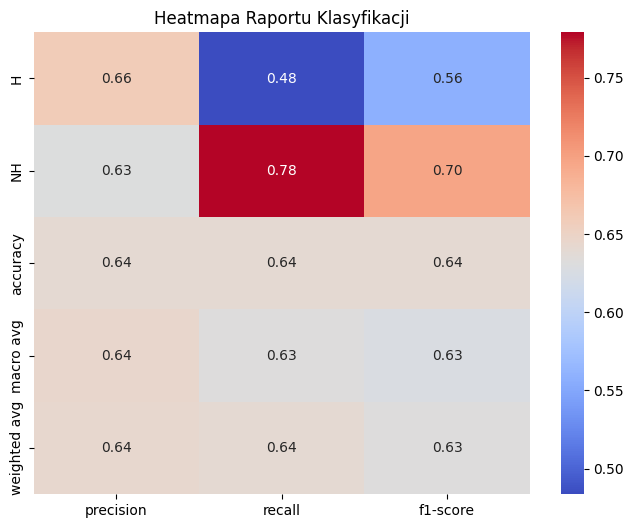

In [16]:
# Oblicz macierz pomyłek
cm = confusion_matrix(y_test, y_pred_decoded)

# Wykres macierzy pomyłek
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Macierz pomyłek')
plt.xlabel('Predykcja')
plt.ylabel('Rzeczywiste')
plt.show()

# Zrób raport klasyfikacji
class_report = classification_report(y_test, y_pred_decoded, output_dict=True)

# Stwórz Heatmapę raportu klasyfikacji
report_df = pd.DataFrame(class_report).iloc[:-1, :].T  # Pomiń ostatnią, agregującą klasę (accuracy)

# Wykres Heatmapy
plt.figure(figsize=(8, 6))
sns.heatmap(report_df[['precision', 'recall', 'f1-score']].astype(float), annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title('Heatmapa Raportu Klasyfikacji')
plt.show()